## 🎯 Use Case 1: Personalized Content Recommendations

This use case demonstrates how clustering helps recommend content that shares similar characteristics with a user’s preferred title.

We:
- Let the user select a title
- Find its cluster using K-Means
- Recommend other titles from the same cluster
- Show the genre focus of the recommendations
- Provide a summary of that cluster’s characteristics


In [ ]:
# 📦 Required Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from ipywidgets import interact, widgets
from IPython.display import display, clear_output, Markdown
import plotly.express as px
import plotly.graph_objects as go

# 🎯 Step 1: Prepare features & train KMeans if needed
if 'cluster_kmeans' not in df.columns:
    features_for_clustering = df[[ 
        'type_encoded', 'rating_encoded', 'duration_int',
        'content_age', 'genre_count'
    ] + [col for col in df.columns if col.startswith("duration_unit_")]]
    
    kmeans_model = KMeans(n_clusters=4, random_state=42)
    df['cluster_kmeans'] = kmeans_model.fit_predict(features_for_clustering)

# 🔍 Step 2: Compute PCA for 2D visualization if not already done
if 'PCA1' not in df.columns or 'PCA2' not in df.columns:
    pca = PCA(n_components=2, random_state=42)
    pca_result = pca.fit_transform(features_for_clustering)
    df['PCA1'] = pca_result[:, 0]
    df['PCA2'] = pca_result[:, 1]

# 🎬 Step 3: Get recommendations based on selected title
def get_recommendations(title_input, cluster_label_col='cluster_kmeans', num_recommendations=5):
    if title_input not in df['title'].values:
        return None, None
    
    cluster_num = df[df['title'] == title_input][cluster_label_col].values[0]
    recs = df[(df[cluster_label_col] == cluster_num) & (df['title'] != title_input)]
    recs = recs[['title', 'listed_in', 'rating']].sample(
        n=min(num_recommendations, len(recs)), random_state=42
    )
    return recs, cluster_num

# 🎭 Step 4: Genre Distribution Plot (Top 10 Genres)
def plot_genres(recs_df):
    genres = recs_df['listed_in'].str.split(',').explode().str.strip()
    genre_counts = genres.value_counts().head(10)

    fig, ax = plt.subplots(figsize=(8, 4), facecolor='none')
    sns.barplot(x=genre_counts.values, y=genre_counts.index, palette='Blues_r', ax=ax)
    
    ax.set_title("🎭 Top Genres in Recommended Titles", fontsize=13)
    ax.set_xlabel("Count")
    ax.set_ylabel("Genre")
    ax.set_facecolor('none')
    sns.despine()
    plt.tight_layout()
    plt.show()

# 📈 Step 5: Plot Clusters and Force Selected Title on Top
def plot_clusters_with_selected(title_input):
    fig_df = df.copy()
    selected_point = fig_df[fig_df['title'] == title_input]
    fig_df = fig_df[fig_df['title'] != title_input]  # Remove from base layer

    # Plot all clusters without selected title
    fig = px.scatter(
        fig_df,
        x='PCA1',
        y='PCA2',
        color='cluster_kmeans',
        color_continuous_scale='Viridis',
        hover_data=['title'],
        opacity=0.75,
        width=850,
        height=550,
        title="📈 Clustering Visualization with Selected Title"
    )

    # Add selected point separately (guaranteed to be on top)
    fig.add_trace(go.Scatter(
        x=selected_point['PCA1'],
        y=selected_point['PCA2'],
        mode='markers+text',
        name='🎯 Selected Title',
        marker=dict(
            color='red',
            size=16,
            symbol='circle',
            line=dict(color='black', width=3)
        ),
        text=[title_input],
        textposition='top center',
        hoverinfo='text'
    ))

    # Final layout tweaks
    fig.update_layout(
        legend=dict(
            x=1.02,
            y=1,
            bgcolor='rgba(255,255,255,0.9)',
            bordercolor='gray',
            borderwidth=0.8
        ),
        coloraxis_colorbar=dict(
            title='Cluster',
            thickness=15,
            x=0.93,
            len=0.8
        ),
        margin=dict(l=40, r=40, t=60, b=40)
    )

    fig.show()

# 📲 Step 6: Dashboard Display Function
def show_recommendation_dashboard(title_input):
    clear_output(wait=True)
    
    display(Markdown(f"## 🎬 Selected Title: `{title_input}`"))
    
    # Get recommendations
    recs, cluster_num = get_recommendations(title_input)
    if recs is None:
        display(Markdown("❌ **Title not found. Please select a valid title.**"))
        return

    # Recommendation Table
    display(Markdown("### 📌 Recommended Titles"))
    display(recs.style.set_table_styles(
        [{'selector': 'th', 'props': [('text-align', 'center')]}]
    ).set_properties(**{'text-align': 'left'}))
    display(Markdown(" "))  

    # Genre Distribution
    display(Markdown("### 🎭 Genre Distribution in Recommendations"))
    plot_genres(recs)
    display(Markdown(" "))

    # Cluster Summary
    display(Markdown("### 📋 Cluster Overview"))
    cluster_df = df[df['cluster_kmeans'] == cluster_num]
    summary = {
        "Most Common Rating": cluster_df['rating'].mode()[0],
        "Avg Duration": round(cluster_df['duration_int'].mean(), 1),
        "Avg Content Age": round(cluster_df['content_age'].mean(), 1),
        "Top Genres": ', '.join(
            cluster_df['listed_in'].str.split(',').explode().str.strip().value_counts().head(3).index.tolist()
        )
    }
    for k, v in summary.items():
        display(Markdown(f"- **{k}**: {v}"))
    
    display(Markdown(" "))

    # Cluster Visualization
    display(Markdown("### 📈 Cluster Visualization with Selected Title"))
    plot_clusters_with_selected(title_input)

# 🎬 Step 7: Dropdown for Title Selection (TOP of Dashboard)
print("📍 Please select a movie or TV show to get recommendations:\n")
title_dropdown = widgets.Dropdown(
    options=sorted(df['title'].dropna().unique()),
    description='🎬 Select Title:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='60%')
)
interact(show_recommendation_dashboard, title_input=title_dropdown)


📍 Please select a movie or TV show to get recommendations:



interactive(children=(Dropdown(description='🎬 Select Title:', layout=Layout(width='60%'), options=('#Alive', '…

<function __main__.show_recommendation_dashboard(title_input)>

## 🎭 Use Case 2: Top Genres per Cluster

Each cluster groups together titles with similar characteristics. By analyzing the genres in each cluster, we can understand what type of content dominates each group.

This helps in:
- Labeling each cluster (e.g., "Thrillers", "Comedy", etc.)
- Understanding audience preferences
- Supporting business insights like content category expansion


In [13]:
# 📦 Required Imports
from ipywidgets import interact, widgets
from IPython.display import display, clear_output

# 🎯 Data preparation for genre summary
def prepare_cluster_genre_summary(df, cluster_col='cluster_kmeans', top_n=5):
    summary = {}
    charts = {}

    for cluster in sorted(df[cluster_col].unique()):
        cluster_df = df[df[cluster_col] == cluster]
        genres = cluster_df['listed_in'].str.split(',').explode().str.strip()
        top_genres = genres.value_counts().head(top_n)

        summary[cluster] = top_genres.index.tolist()
        charts[cluster] = top_genres

    return summary, charts

# Prepare summary and chart data
genre_summary_dict, genre_chart_data = prepare_cluster_genre_summary(df)

# 📊 Plotting + Table per cluster
def show_cluster_genres(cluster_num):
    clear_output(wait=True)
    
    print(f"🎯 Cluster {cluster_num} — Top Genres:\n")
    
    # Display bar chart
    top_genres = genre_chart_data[cluster_num]
    plt.figure(figsize=(7, 4))
    sns.barplot(x=top_genres.values, y=top_genres.index, palette='viridis')
    plt.title(f"🎭 Top Genres in Cluster {cluster_num}")
    plt.xlabel("Count")
    plt.ylabel("Genre")
    sns.despine()
    plt.tight_layout()
    plt.show()
    
    # Display table row for selected cluster
    genres = genre_summary_dict[cluster_num]
    summary_df = pd.DataFrame([genres], columns=[f'Top Genre {i+1}' for i in range(len(genres))])
    summary_df.index = [f'Cluster {cluster_num}']
    print("📋 Genre Summary Table:")
    display(summary_df)

# 🎬 Dropdown to choose cluster
interact(show_cluster_genres, cluster_num=widgets.Dropdown(
    options=sorted(df['cluster_kmeans'].unique()),
    description="Select Cluster:",
    layout=widgets.Layout(width='50%'),
    style={'description_width': 'initial'}
))


interactive(children=(Dropdown(description='Select Cluster:', layout=Layout(width='50%'), options=(0, 1, 2, 3)…

<function __main__.show_cluster_genres(cluster_num)>

## 🕒 Use Case 3: Content Age Distribution by Cluster

We explore how old the content is within each cluster.

Why this matters:
- Older clusters may contain classics or timeless content
- Newer clusters may be more relevant for trending recommendations

Included:
- 📊 Boxplot to compare age range across clusters
- 🎻 Violin plot for distribution shape
- 📋 Summary table showing average, median, youngest, and oldest content per cluster


C:\Users\kavya\AppData\Local\Temp\ipykernel_39908\2636462161.py:10: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()
c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


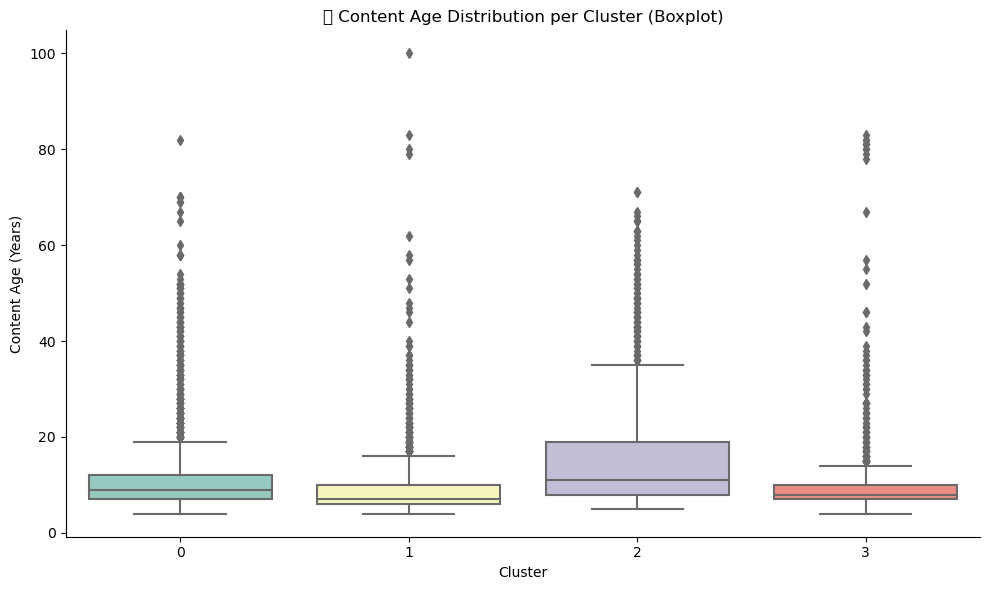

C:\Users\kavya\AppData\Local\Temp\ipykernel_39908\2636462161.py:20: UserWarning: Glyph 127931 (\N{VIOLIN}) missing from current font.
  plt.tight_layout()
c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 127931 (\N{VIOLIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


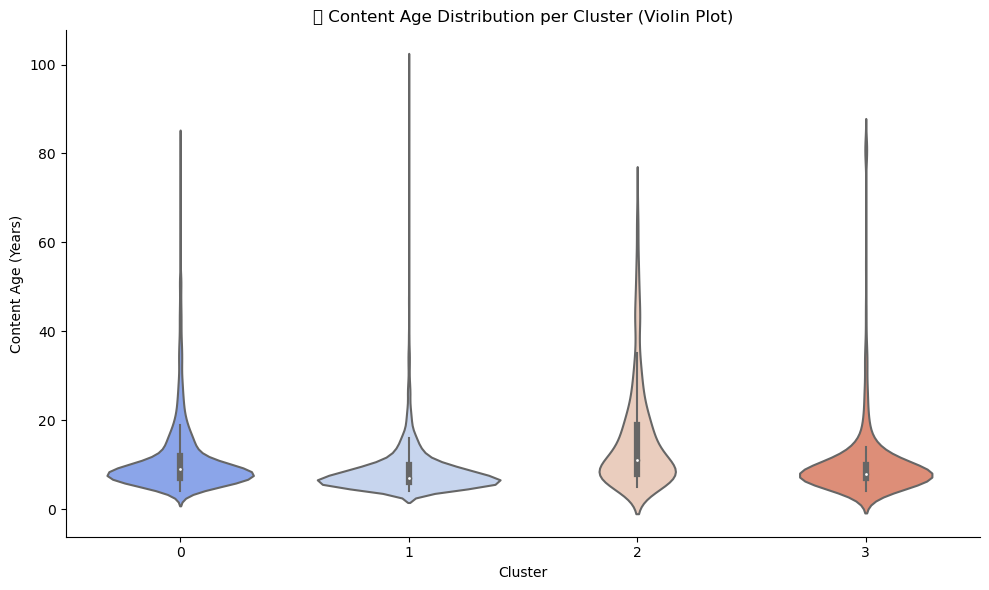

📋 Content Age Summary Table:


,Avg Age,Median Age,Youngest,Oldest
cluster_kmeans,,,,
0,11.3,9.0,4,82
1,8.9,7.0,4,100
2,15.9,11.0,5,71
3,10.5,8.0,4,83


In [14]:
# 🎯 Use Case 3: Content Age Distribution per Cluster (Boxplot + Violin + Summary Table)

# 📊 Boxplot of content age
plt.figure(figsize=(10, 6))
sns.boxplot(x='cluster_kmeans', y='content_age', data=df, palette='Set3')
plt.title("📊 Content Age Distribution per Cluster (Boxplot)")
plt.xlabel("Cluster")
plt.ylabel("Content Age (Years)")
sns.despine()
plt.tight_layout()
plt.show()

# 🎻 Violin plot of content age
plt.figure(figsize=(10, 6))
sns.violinplot(x='cluster_kmeans', y='content_age', data=df, palette='coolwarm')
plt.title("🎻 Content Age Distribution per Cluster (Violin Plot)")
plt.xlabel("Cluster")
plt.ylabel("Content Age (Years)")
sns.despine()
plt.tight_layout()
plt.show()

# 📋 Summary table of content age
age_summary = df.groupby('cluster_kmeans')['content_age'].agg(['mean', 'median', 'min', 'max']).round(1)
age_summary.rename(columns={
    'mean': 'Avg Age', 'median': 'Median Age', 'min': 'Youngest', 'max': 'Oldest'
}, inplace=True)

print("📋 Content Age Summary Table:")
display(age_summary)


## 📆 Use Case 4: Year-wise Content Trends per Cluster

This use case shows how Netflix’s content trends have changed over time for each cluster.

Why it matters:
- Netflix can track how much content is added over years per group
- Helps plan future investments, marketing, or advertising based on content types
- Shows which clusters are **growing**, **declining**, or **stable**

Visualizations:
- 📊 Stacked bar chart of content count by year and cluster
- 📈 Line plots per cluster to analyze trend over time
- 📋 Optional table: top 5 years with most content per cluster


C:\Users\kavya\AppData\Local\Temp\ipykernel_39908\3569005.py:16: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  plt.tight_layout()


<Figure size 1400x600 with 0 Axes>

c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


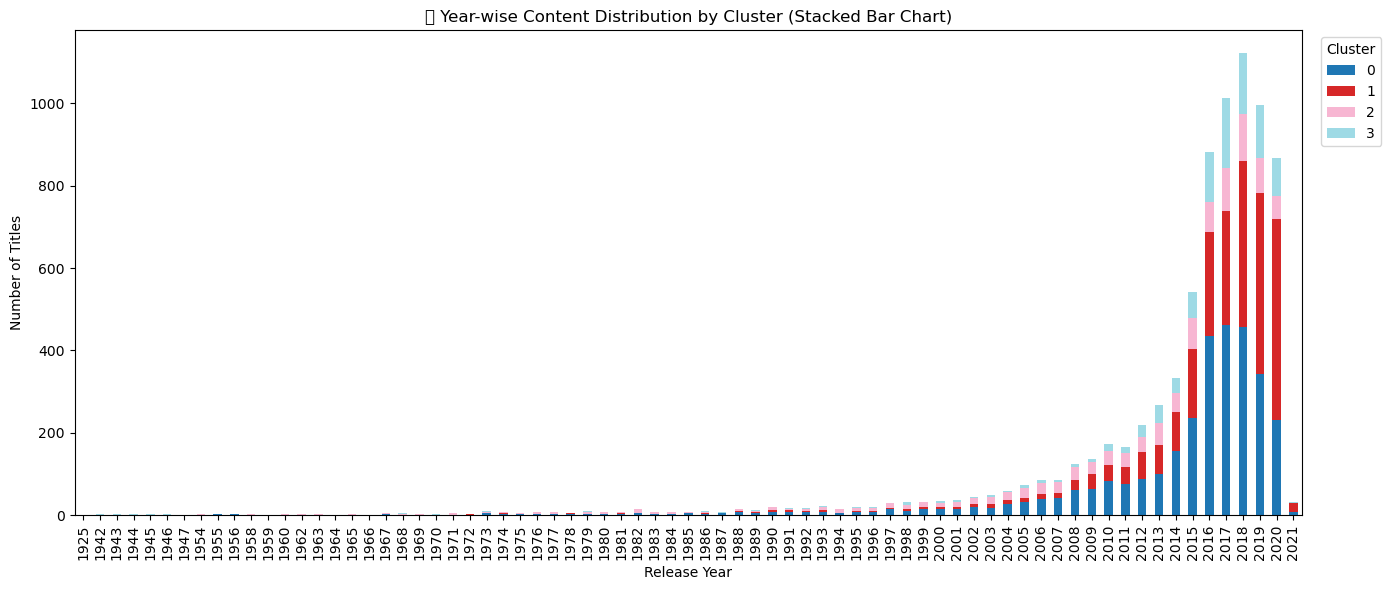

C:\Users\kavya\AppData\Local\Temp\ipykernel_39908\3569005.py:29: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


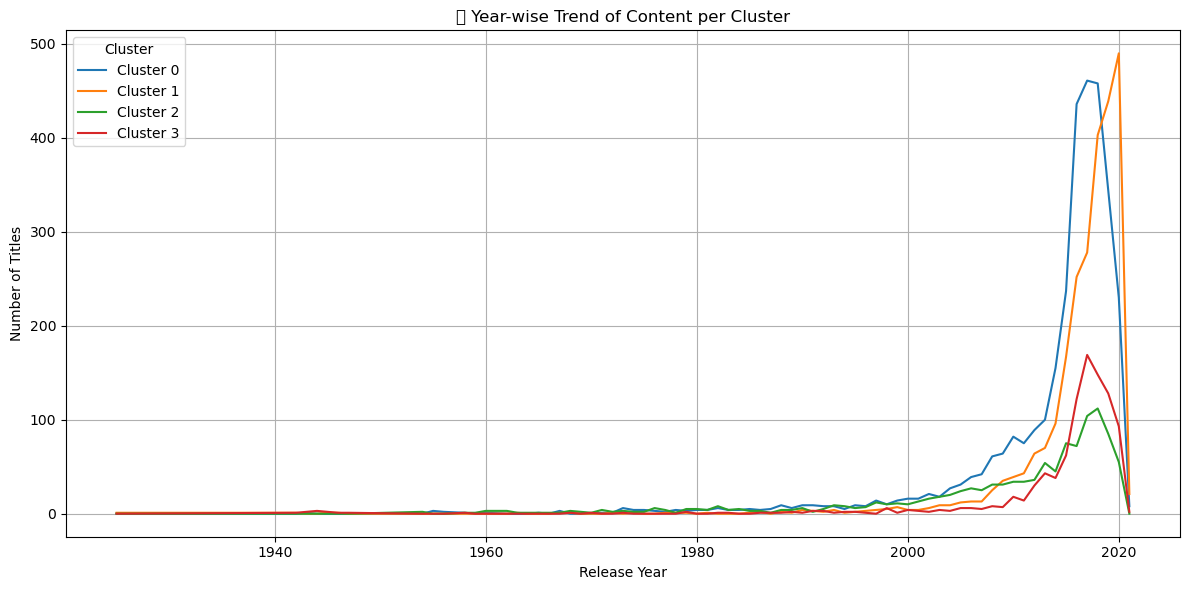

📋 Top 5 Content Years per Cluster:


,Top Year 1,Top Year 2,Top Year 3,Top Year 4,Top Year 5
Cluster 0,2017,2018,2016,2019,2015
Cluster 1,2020,2019,2018,2017,2016
Cluster 2,2018,2017,2019,2015,2016
Cluster 3,2017,2018,2019,2016,2020


In [15]:
# 🎯 Use Case 4: Year-wise Content Trends per Cluster

# Ensure 'release_year' is numeric and drop missing values
df_clean_year = df[df['release_year'].notnull()].copy()
df_clean_year['release_year'] = df_clean_year['release_year'].astype(int)

# 📊 1. Stacked Bar Chart: Content Count per Year per Cluster
year_cluster_counts = df_clean_year.groupby(['release_year', 'cluster_kmeans']).size().unstack(fill_value=0)

plt.figure(figsize=(14, 6))
year_cluster_counts.plot(kind='bar', stacked=True, colormap='tab20', figsize=(14, 6))
plt.title("📊 Year-wise Content Distribution by Cluster (Stacked Bar Chart)")
plt.xlabel("Release Year")
plt.ylabel("Number of Titles")
plt.legend(title='Cluster', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 📈 2. Line Plot: Cluster-wise Content Volume Over Time
plt.figure(figsize=(12, 6))
for cluster in year_cluster_counts.columns:
    plt.plot(year_cluster_counts.index, year_cluster_counts[cluster], label=f'Cluster {cluster}')
    
plt.title("📈 Year-wise Trend of Content per Cluster")
plt.xlabel("Release Year")
plt.ylabel("Number of Titles")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()

# 📋 3. Optional Table: Top 5 Years with Most Content for Each Cluster
top_years_summary = {}
for cluster in year_cluster_counts.columns:
    top_years = year_cluster_counts[cluster].sort_values(ascending=False).head(5)
    top_years_summary[f'Cluster {cluster}'] = top_years.index.tolist()

top_years_df = pd.DataFrame.from_dict(top_years_summary, orient='index')
top_years_df.columns = [f'Top Year {i+1}' for i in range(top_years_df.shape[1])]

print("📋 Top 5 Content Years per Cluster:")
display(top_years_df)


# ✅ Project Summary & Conclusion

This project successfully used unsupervised learning to cluster Netflix content into meaningful groups based on genre, rating, duration, and age.

## 🔍 Techniques Used:
- Data Cleaning & Feature Engineering
- KMeans, Hierarchical, and DBSCAN Clustering
- Dimensionality Reduction (PCA)
- Model Evaluation (Silhouette, Davies-Bouldin)
- Dashboard-style business visualizations

## 💼 Business Use Cases Addressed:
1. 🎯 Personalized Recommendations – Recommend content from same cluster
2. 🎭 Genre Focus – Top genres per cluster for better targeting
3. 🕒 Content Age – Distribution analysis for content strategy
4. 📆 Year-wise Trends – Detect cluster growth or decline over time

## ✅ Final Takeaways:
- Clustering can effectively group content into niche categories
- Helps Netflix improve recommendations, marketing, and content planning
- Visual dashboards made insights clear, actionable, and presentation-ready


